In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

TF version: 2.1.0
TFP version: 0.9.0


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

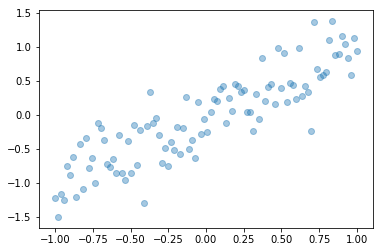

In [ ]:
# Use the same data as before -- create and plot 100 data points

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.show()

In [ ]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable

def prior_dist(kernel_size,bias_size,dtype=None):
    n=kernel_size+bias_size
    prior_modeel=Sequential([tfpl.DistributionLambda(lambda t : tfd.MultivariateNormalDiag(loc=tf.zeros(n),scale_diag=tf.ones(n)))])
    return prior_modeel

In [ ]:
# Define variational posterior weight distribution -- multivariate Gaussian
def posterior_dist(kernel_size,bias_size,dtype=None):
    n=kernel_size+bias_size
    posterior_model=Sequential([tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n),dtype=dtype),
                               tfpl.MultivariateNormalTriL(n)])
    return posterior_model


#### Create the model with `DenseVariational` layers

In [ ]:
# Create linear regression model with weight uncertainty: weights are
# distributed according to posterior (and, indirectly, prior) distribution
input_layer = tf.keras.layers.Input(shape=(1,))
model=Sequential([input_layer,tfpl.DenseVariational(units=1,make_prior_fn=prior_dist,make_posterior_fn=posterior_dist,
                                       kl_weight=1/x_train.shape[0],
                                       kl_use_exact=True)])
model.compile(loss=MeanSquaredError(),optimizer=RMSprop(learning_rate=0.005))

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [ ]:
# Fit the model, just like a deterministic linear regression

model.fit(x_train, y_train, epochs=500, verbose=False)

In [ ]:
# Check out the parameters of the prior and posterior distribution

dummy_input = np.array([[0]])
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)
print('prior mean:           ', model_prior.mean().numpy())
print('prior variance:       ', model_prior.variance().numpy())
print('posterior mean:       ', model_posterior.mean().numpy())
print('posterior covariance: ', model_posterior.covariance().numpy()[0])
print('                      ', model_posterior.covariance().numpy()[1])

prior mean:            [0. 0.]
prior variance:        [1. 1.]
posterior mean:        [ 1.0330361  -0.01242125]
posterior covariance:  [0.01641714 0.00056351]
                       [0.00056351 0.00635106]



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



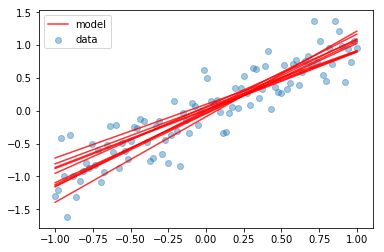

In [ ]:
# Plot an ensemble of linear regressions, with weights sampled from
# the posterior distribution

plt.scatter(x_train, y_train, alpha=0.4, label='data')
for _ in range(10):
    y_model = model(x_train)
    if _ == 0:
        plt.plot(x_train, y_model, color='red', alpha=0.8, label='model')
    else:
        plt.plot(x_train, y_model, color='red', alpha=0.8)        
plt.legend()
plt.show()

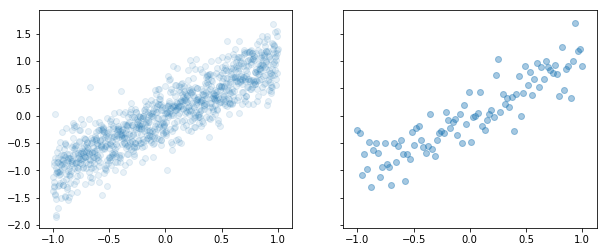

In [ ]:
# Create two datasets, one with 1000 points, another with 100

x_train_1000 = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train_1000 = x_train_1000 + 0.3*np.random.randn(1000)[:, np.newaxis]

x_train_100 = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train_100 = x_train_100 + 0.3*np.random.randn(100)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax1.scatter(x_train_1000, y_train_1000, alpha=0.1)
ax2.scatter(x_train_100, y_train_100, alpha=0.4)
plt.show()

In [ ]:
# Train a model on each dataset

model_1000 = Sequential([tfpl.DenseVariational(input_shape=(1,), 
                                               units=1,
                                               make_prior_fn=prior_dist, 
                                               make_posterior_fn=posterior_dist,
                                               kl_weight=1/1000)])

model_100 = Sequential([tfpl.DenseVariational(input_shape=(1,), 
                                              units=1,
                                              make_prior_fn=prior_dist, 
                                              make_posterior_fn=posterior_dist,
                                              kl_weight=1/100)])

model_1000.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model_100.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))

model_1000.fit(x_train_1000, y_train_1000, epochs=50, verbose=False)
model_100.fit(x_train_100, y_train_100, epochs=500, verbose=False)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



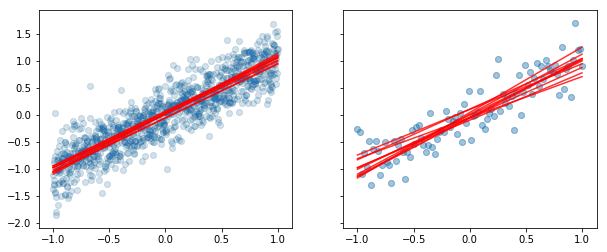

In [ ]:
# Plot an ensemble of linear regressions from each model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for _ in range(10):
    y_model_1000 = model_1000(x_train_1000)
    ax1.scatter(x_train_1000, y_train_1000, color='C0', alpha=0.02)
    ax1.plot(x_train_1000, y_model_1000, color='red', alpha=0.8)
    y_model_100 = model_100(x_train_100)
    ax2.scatter(x_train_100, y_train_100, color='C0', alpha=0.05)
    ax2.plot(x_train_100, y_model_100, color='red', alpha=0.8)
plt.show()